In [20]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import pandas_profiling

import env
import acquire
import prep
import explore_final
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from statsmodels.formula.api import ols

## Initial Hypothesis

Square footage and home value extremes are leading drivers of log error.

## Acquire and summarize data

Initial Dataframe included single family residence homes with 40+ initial fields brought in.

After reviewing the data for missing values, multicollinearity, and low correlation we dropped our data down to 14 columns and 54,000 rows. 300 values were imputed on lotsizesquarefeet with the mean in order to maintain the column.

In [21]:
#nmysql query single family residence from zillow DB
df = prep.prep_df()

In [22]:
df.shape

(55553, 10)

In [23]:
#testing removing outliers 3 times the IQR
df = prep.remove_outliers_iqr(df,['bathrooms', 'bedrooms', 'sqft', 'tax_value', 'lotsizesquarefeet','yearbuilt', 'structuretaxvaluedollarcnt', 'logerror'])

55313
55292
54850
53650
50432
50432
49789
48054


## Data prep and test/train split

Our initial dataframe was split into 70/30 train/test adding a tax_per_sqft field. Random State 123 was used.

In [24]:
#train test split and adding a tax_per_sqft field
train, test = prep.get_train_and_test(df)

In [25]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror,tax_per_sqft
50827,2.0,3.0,1724.0,122538.0,33812747.0,-117956786.0,6000.0,1968.0,85967.0,-0.002243,71.077726
17912,2.0,3.0,1634.0,177026.0,34122763.0,-117783893.0,9842.0,1976.0,135565.0,0.010858,108.339045


In [26]:
X_train, y_train, X_test, y_test = prep.get_baseline_train_test_split(df)

In [27]:
X_train.head(2)

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt
50827,2.0,3.0,1724.0,122538.0,6000.0,1968.0,85967.0
17912,2.0,3.0,1634.0,177026.0,9842.0,1976.0,135565.0


## Initial exploration and feature selection

In [28]:
#adding a baseline yhat as mean of log error and residual amt based off that.
train['mean_logerror'] = train.logerror.mean()
train['residual'] = train['logerror']- train['mean_logerror']

In [29]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror,tax_per_sqft,mean_logerror,residual
50827,2.0,3.0,1724.0,122538.0,33812747.0,-117956786.0,6000.0,1968.0,85967.0,-0.002243,71.077726,0.007046,-0.009289
17912,2.0,3.0,1634.0,177026.0,34122763.0,-117783893.0,9842.0,1976.0,135565.0,0.010858,108.339045,0.007046,0.003812


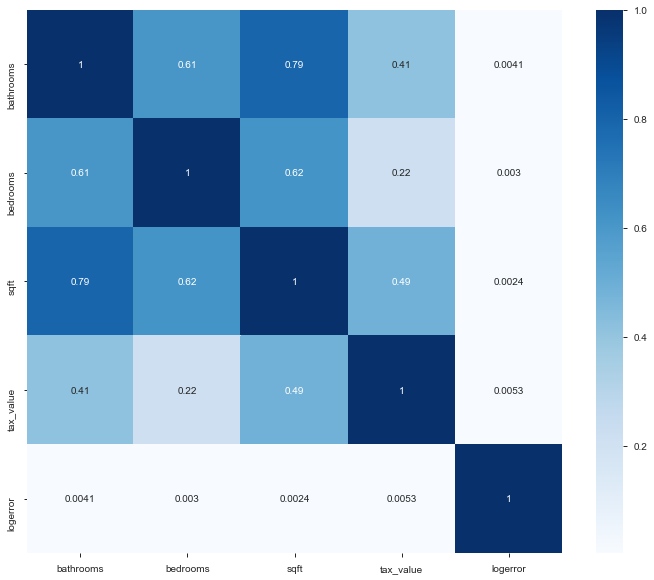

In [30]:
# Heatmap of possible initial features
plt.figure(figsize=(12,10))
subset = train[['bathrooms','bedrooms','sqft','tax_value','logerror']]
cor = subset.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

## Initial Baseline score

In [31]:
baseline = mean_squared_error(train.logerror,train.mean_logerror)
print(baseline)

0.00394287772334053


## MVP

After some basic feature engineering and selection we trained the new model on just sqft and bedrooms. This model performed slightly better than our baseline.

In [32]:
#MSE of sqft and bedrooms as x variables
x = train[['sqft','bedrooms']]
y = train[['logerror']]
ols_model = ols('y ~ x', data=train).fit()
train['yhat'] = ols_model.predict(x)

In [33]:
model1 = mean_squared_error(train.logerror,train.yhat)
print(model1)
model1 < baseline

0.003942840226501951


True

## Exploration

We began our exploration by clustering on the y variable.

   k         sse
0  1  129.775877
1  2   64.972226
2  3   32.588346
3  4   19.426789
4  5   12.759536
5  6    9.131377
6  7    6.768690
7  8    5.165860
8  9    4.098599


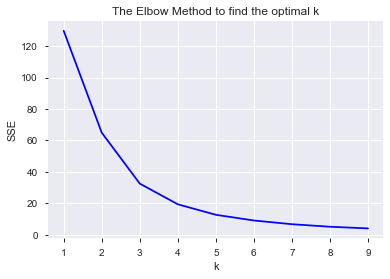

In [34]:
explore_final.elbow_plot(y_train)

In [35]:
#Clustered by logerror. function takes in y_train,X_train, and num_clusters
train = explore_final.target_cluster(y_train,X_train,6)

In [36]:
train.groupby('cluster').mean().sort_values(by='logerror')

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror
cluster,,,,,,,,
3,2.079221,3.207143,1688.960390,355769.251299,6909.986004,1958.977922,136166.300691,-0.143078
5,2.106035,3.237107,1698.640060,358081.599401,6912.691138,1959.856195,138559.857593,-0.058512
0,2.110939,3.248263,1704.004507,357317.288638,6975.067430,1960.271268,139024.842534,-0.010883
2,2.100648,3.240259,1699.026008,357561.731413,7023.033409,1959.941216,139010.854374,0.025604
4,2.111809,3.251389,1711.441922,357970.830717,7006.796383,1959.653224,138713.071412,0.077396
1,2.110083,3.204212,1693.596682,370372.281429,6940.276628,1959.433312,139552.136639,0.163531


In [37]:
train.cluster.value_counts()

0    10650
2    10343
5     4673
4     4141
1     1567
3     1540
Name: cluster, dtype: int64